In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline

import pandas as pd
import numpy as np

# pd.options.display.max_columns = 50
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', 50)

plt.rcParams.update({'figure.figsize':(15,6), 'figure.dpi':60})
plt.style.use('fivethirtyeight')

In [ ]:
# command 要先上面执行这些！！！！
# !pip freeze
# !pip install PyPDF2
# !pip install gensim
# !pip install nltk
# !pip install WordCloud
# !pip install pdfminer3
# !pip install mlflow
# !pip3 install spacy
# !pip3 install pyLDAvis==2.1.2

In [2]:
import sys  

sys.path.append('../src') 


In [12]:
#import edge

ModuleNotFoundError: No module named 'edge'

In [36]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this

# PDF text extraction
from pdfminer3.layout import LAParams, LTTextBox
from pdfminer3.pdfpage import PDFPage
from pdfminer3.pdfinterp import PDFResourceManager
from pdfminer3.pdfinterp import PDFPageInterpreter
from pdfminer3.converter import PDFPageAggregator
from pdfminer3.converter import TextConverter

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

# Others
import requests
import io
import string
import re
from pprint import pprint
from tqdm.notebook import tqdm
import io
import json
from PIL import Image

In [4]:

DATA_FOLDER = '../data/'
PDF_FOLDER = '../pdf/'
#createfolder(DATA_FOLDER)
#createfolder(PDF_FOLDER)

In [5]:
import nltk
#nltk.download('punkt')
#nltk.download('stopwords')

import spacy
#spacy.cli.download("en_core_web_sm")
nlp = spacy.load("en_core_web_sm", disable=['ner'])

In [6]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

from sklearn.feature_extraction import text
stop_words = text.ENGLISH_STOP_WORDS.union(stop_words)

In [11]:
', '.join(stop_words)

"i, though, wouldn, that'll, do, per, next, shouldn, had, describe, you'd, could, between, further, thereafter, thereupon, will, hasn, mill, among, against, myself, wasn't, first, seem, besides, back, yet, latterly, already, formerly, fifty, why, only, none, won, cry, often, should, am, whoever, such, couldn't, be, needn't, but, go, anyhow, one, herself, even, someone, a, itself, amoungst, us, see, whose, thence, who, amongst, how, full, more, couldnt, yours, onto, together, beside, were, above, y, by, thru, eleven, below, still, her, ourselves, serious, ll, ve, before, these, thereby, fifteen, latter, eg, meanwhile, either, nothing, nowhere, anything, others, eight, system, as, aren't, hundred, some, behind, put, ie, just, that, ma, nine, interest, into, t, whereupon, ain, haven't, nor, please, mustn, fill, noone, get, part, being, thus, the, empty, along, whom, ltd, forty, then, you've, whereas, weren, now, whereafter, two, for, wasn, throughout, over, weren't, side, perhaps, namely,

In [19]:
report_company = 'NVIDIA'
report_ticker = 'NVDA'
report_year = '2021'
report_url = 'https://images.nvidia.com/aem-dam/Solutions/documents/FY2021-NVIDIA-CSR-Social-Responsibility.pdf'

In [23]:
def extract_pdf(file, verbose=False):
    
    if verbose:
        print('Processing {}'.format(file))

    try:
        resource_manager = PDFResourceManager()
        fake_file_handle = io.StringIO()
        codec = 'utf-8'
        laparams = LAParams()

        converter = TextConverter(resource_manager, fake_file_handle, codec=codec, laparams=laparams)
        page_interpreter = PDFPageInterpreter(resource_manager, converter)
        
        password = ""
        maxpages = 0
        caching = True
        pagenos = set()

        content = []

        for page in PDFPage.get_pages(file,
                                      pagenos, 
                                      maxpages=maxpages,
                                      password=password,
                                      caching=True,
                                      check_extractable=False):

            page_interpreter.process_page(page)

            content.append(fake_file_handle.getvalue())

            fake_file_handle.truncate(0)
            fake_file_handle.seek(0)        

        text = '##PAGE_BREAK##'.join(content)

        # close open handles
        converter.close()
        fake_file_handle.close()
        
        return text

    except Exception as e:
        print(e)

        # close open handles
        converter.close()
        fake_file_handle.close()

        return ""

In [24]:
def extract_content(url):
    """
    A simple user define function that, given a url, download PDF text content
    Parse PDF and return plain text version
    """
    headers={"User-Agent":"Mozilla/5.0"}

    try:
        # retrieve PDF binary stream
        r = requests.get(url, allow_redirects=True, headers=headers)
        
        # access pdf content
        text = extract_pdf(io.BytesIO(r.content))

        # return concatenated content
        return text

    except:
        return ""

In [25]:
report_content = extract_content(report_url)


In [27]:
print(report_content)

2021 NVIDIA
CORPORATE SOCIAL  
RESPONSIBILITY
REPORT

##PAGE_BREAK##TABLE OF CONTENTS

01 EXECUTIVE MESSAGES

05 SOCIAL

Letter from our CEO
Q&A with our CFO

02 PRIORITIES AND 
STAKEHOLDERS
Setting Priorities
Stakeholder Engagement
Our Response to COVID-19

03 GOVERNANCE

Board Governance
Ethical Conduct

04 ECONOMIC
PRIORITY: Innovation
PRIORITY: Business Model and Competitiveness
PRIORITY: Cybersecurity and Data Privacy
PRIORITY: Trade Issues
Business Continuity Management
Public Policy Engagement
Customer Relations 

02
05

07
10
14

16
18

19
20
22
23
24
25
27

PRIORITY: Supply Chain Management  
and Product Quality
PRIORITY: Employee Health and Safety
PRIORITY: Talent Strategy, Diversity and Inclusion
Employee Engagement
Community Engagement
Trustworthy AI
Product Safety

06 ENVIRONMENTAL

Climate Change and Greenhouse Gas Emissions
Energy, Water, and Waste
Data Centers, Labs, and Office Management
Environmental Impact of Products

07 GOALS AND PERFORMANCE

FY21 Goals and Perfor

In [28]:
report = {'company':report_company, 'year':report_year, 'ticker':report_ticker, 
          'url':report_url, 'content':report_content}

with open(DATA_FOLDER + report_company+report_year+'.json', "w") as outfile:  
    json.dump(report, outfile)

# Open File

In [7]:
with open(DATA_FOLDER + 'NVIDIA2021.json') as inputfile:
     report = json.load(inputfile)

# Text Cleaning

In [9]:
def remove_non_ascii(text):
    printable = set(string.printable)
    return ''.join(filter(lambda x: x in printable, text))

#def not_header(line):
    # as we're consolidating broken lines into paragraphs, we want to make sure not to include headers
    #return not line.isupper()

def extract_sentences(nlp, text):
    """
    Extracting ESG statements from raw text by removing junk, URLs, etc.
    We group consecutive lines into paragraphs and use spacy to parse sentences.
    """
    MIN_WORDS_PER_PAGE = 500
    
    pages = text.split('##PAGE_BREAK##')
#     print('Number of Pages: {}'.format(len(pages)))

    lines = []
    for page in pages:
        
        # remove non ASCII characters
        text = remove_non_ascii(page)
        
        if len(text.split(' ')) < MIN_WORDS_PER_PAGE:
#             print('Skipped Page: {}'.format(len(text.split(' '))))
            continue
        
        prev = ""
        for line in text.split('\n\n'):
            # aggregate consecutive lines where text may be broken down
            # only if next line starts with a space or previous does not end with dot.
            if(line.startswith(' ') or not prev.endswith('.')):
                prev = prev + ' ' + line
            else:
                # new paragraph
                lines.append(prev)
                prev = line

        # don't forget left-over paragraph
        lines.append(prev)
        lines.append('##SAME_PAGE##')
        
    lines = '  '.join(lines).split('##SAME_PAGE##')
    
    # clean paragraphs from extra space, unwanted characters, urls, etc.
    # best effort clean up, consider a more versatile cleaner
    
    sentences = []
    pages_content = []

    for line in lines[:-1]:
        # removing header number
        line = re.sub(r'^\s?\d+(.*)$', r'\1', line)
        # removing trailing spaces
        line = line.strip()
        # words may be split between lines, ensure we link them back together
        line = re.sub(r'\s?-\s?', '-', line)
        # remove space prior to punctuation
        line = re.sub(r'\s?([,:;\.])', r'\1', line)
        # ESG contains a lot of figures that are not relevant to grammatical structure
        line = re.sub(r'\d{5,}', r' ', line)
        # remove emails
        line = re.sub(r'\S*@\S*\s?', '', line)
        # remove mentions of URLs
        line = re.sub(r'((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*', r' ', line)
        # remove multiple spaces
        line = re.sub(r'\s+', ' ', line)
        # join next line with space
        line = re.sub(r' \n', ' ', line)
        line = re.sub(r'.\n', '. ', line)
        line = re.sub(r'\x0c', ' ', line)
        
        pages_content.append(str(line).strip())

        # split paragraphs into well defined sentences using spacy
        for part in list(nlp(line).sents):
            sentences.append(str(part).strip())

#           sentences += nltk.sent_tokenize(line)
            
    # Only interested in full sentences and sentences with 10 to 100 words.
    sentences = [s for s in sentences if re.match('^[A-Z][^?!.]*[?.!]$', s) is not None]
    sentences = [s.replace('\n', ' ') for s in sentences]
    sentences = [s for s in sentences if (len(s.split(' ')) > 10) & (len(s.split(' ')) < 100)]

    return pages_content, sentences

In [10]:
report_pages, report_sentences = extract_sentences(nlp, report['content'])

In [13]:
print(report_sentences)

['Governance The Nominating and Corporate Governance Committee (NCGC) of our Board is responsible for reviewing and discussing with management our practices concerning environmental, social, and corporate governance.', 'Our head of CSR reviews stakeholder inputs with and collects feedback on priorities from the NCGC each year.', 'The priorities include issues that are of utmost importance to our stakeholders, such as climate change, human rights, and diversity and inclusion.', 'Starting in FY22, NVIDIA management will periodically report to the NCGC about the companys policies and practices regarding governmental relations, public policy, and related expenditures.', 'ETHICAL CONDUCT We strive to achieve the highest standards of ethical conduct in all our business dealings.', 'Our codes of conduct and policies guide how we conduct ourselves in our professional relationships toward our customers, partners, competitors, vendors, government regulators, shareholders, fellow employees, and t

In [14]:
footers = ['2021 NVIDIA CSR REPORT  ExECUTIVE MESSAGES', 'Table Of Contents']

for footer in footers:
    report_pages = [p.replace(footer, "").strip() for p in report_pages]
    report_sentences = [p.replace(footer, "").strip() for p in report_sentences]    

# Tokenization, Bigrams and Lemmatization

In [15]:
def run_NLP(content):

    def sent_to_words(sentences):
        for sentence in sentences:
            yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

    # Define functions for stopwords, bigrams, trigrams and lemmatization
    def remove_stopwords(texts):
        return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

    def make_bigrams(texts):
        return [bigram_mod[doc] for doc in texts]

    def make_trigrams(texts):
        return [trigram_mod[bigram_mod[doc]] for doc in texts]

    def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
        """https://spacy.io/api/annotation"""
        texts_out = []
        for sent in texts:
            doc = nlp(" ".join(sent)) 
            texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        return texts_out

    data_words = list(sent_to_words(content))

    # Build the bigram and trigram models
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)

    # Remove Stop Words
    data_words_nostops = remove_stopwords(data_words)

    # Form Bigrams
    data_words_bigrams = make_bigrams(data_words_nostops)

    # Do lemmatization keeping only noun, adj, vb, adv
    data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    
    return data_lemmatized

In [16]:
data_lemmatized = run_NLP(report_pages)

In [17]:
report_sentences_lemma = [' '.join(w) for w in data_lemmatized]

In [18]:
import random
report_sentences_lemma[random.randint(0, len(report_sentences_lemma))]

'cover system infrastructure policy procedure ensure business continuity operational resilience process address operational interruption external global circumstance bcm program identify steering bcm team core value business continuity management business continuity management bcm focus protect core value philosophy bcm identify realistic threat potential impact core value business operation design formal framework respond believe resilience achieve embed redundancy diversity response framework steering committee executive support business leader follow function corporate communication cybersecurity facility finance global security human resource information technology operation function plan identify address potential risk effort support robust infrastructure system policy procedure design mitigate risk protect safety trust employee customer unexpected event cyberattack business disruption natural disaster occur response covid closed worldwide office employee prevent spread access sit

# WordCloud

In [22]:
# context specific keywords not to include in topic modelling
fsi_stop_words = [
  'plc', 'group', 'target',
  'track', 'capital', 'holding',
  'report', 'annualreport',
  'csr', 'bank', 'report',
  'long', 'make'
]

fsi_stop_words.append(report_company)
fsi_stop_words.append('citi')

# our list contains all english stop words + companies names + specific keywords
stop_words = stop_words.union(fsi_stop_words)

In [23]:
print(fsi_stop_words)

['plc', 'group', 'target', 'track', 'capital', 'holding', 'report', 'annualreport', 'csr', 'bank', 'report', 'long', 'make', 'NVIDIA', 'citi']


In [54]:
import imageio
#mask= np.array(Image.open('../data/Butterfly2.png'))
#mask[mask == 0] =255
##print(mask)
##import WordCloud

In [65]:
mask = imageio.imread("../data/Butterfly1_副本.png")

<>:9: DeprecationWarning: invalid escape sequence \W
<>:9: DeprecationWarning: invalid escape sequence \W
C:\Users\jenny\AppData\Local\Temp/ipykernel_8676/404903776.py:9: DeprecationWarning: invalid escape sequence \W
  font_path='C:\Windows\Fonts\MTCORSVA.TTF',


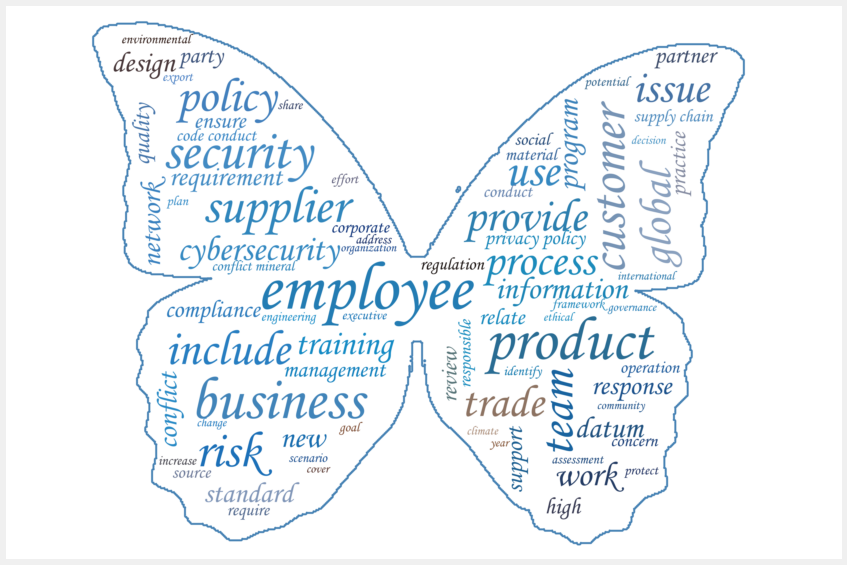

In [92]:
import wordcloud 

# aggregate all 7200 records into one large string to run wordcloud on term frequency
large_string = ' '.join(report_sentences_lemma)

color_new = wordcloud.ImageColorGenerator(mask)
# use 3rd party lib to compute term freq., apply stop words
word_cloud = WordCloud(
    font_path='C:\Windows\Fonts\MTCORSVA.TTF',
    background_color="white",
    scale= 10,
    max_words=80,
    max_font_size = 50,
    width=700, 
    height=400, 
    stopwords=stop_words, 
    contour_width=25, 
    contour_color='steelblue',
    color_func=color_new,
    mask = mask
)

# display our wordcloud across all records
plt.figure(figsize=(16,16))
word_cloud.generate(large_string)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# TFIDF - Unigram and Bigram Analysis

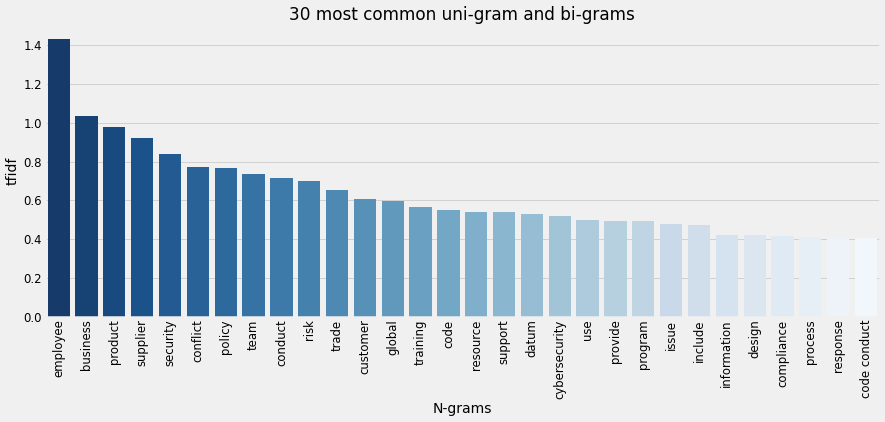

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Run bi-gram TF-IDF frequencies
bigram_tf_idf_vectorizer = TfidfVectorizer(stop_words=stop_words, ngram_range=(1,2), min_df=3, use_idf=True)## min_df改了一下
bigram_tf_idf = bigram_tf_idf_vectorizer.fit_transform(report_sentences_lemma)

# Extract bi-grams names
words = bigram_tf_idf_vectorizer.get_feature_names()

# extract our top 10 ngrams
total_counts = np.zeros(len(words))
for t in bigram_tf_idf:
    total_counts += t.toarray()[0]

count_dict = (zip(words, total_counts))
count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:30]
words = [w[0] for w in count_dict]
counts = [w[1] for w in count_dict]
x_pos = np.arange(len(words)) 

# Plot top 10 ngrams
plt.figure(figsize=(16, 6))
plt.subplot(title='30 most common uni-gram and bi-grams')
sns.barplot(x_pos, counts, palette='Blues_r')
plt.xticks(x_pos, words, rotation=90) 
plt.xlabel('N-grams')
plt.ylabel('tfidf')
plt.show()

# Topic Modeling and Latent Dirichlet Allocation

In [27]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [28]:
results = []
optimal_score = 0
optimal_model = None

for num_of_topics in tqdm(range(2,15,1)):
    
    result = {}
    
    # Build LDA model
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=id2word,
                                                num_topics=num_of_topics, 
                                                random_state=42,
                                                update_every=1,
                                                chunksize=5,
                                                passes=20,
                                                alpha='auto',
                                                per_word_topics=True) 

    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    if optimal_score < coherence_model_lda.get_coherence():
        optimal_score = coherence_model_lda.get_coherence()
        optimal_model = lda_model

    result['num_of_topics'] = num_of_topics
    result['perplexity'] = lda_model.log_perplexity(corpus)
    result['coherence_score'] = coherence_model_lda.get_coherence()
    
    results.append(result)
    
results = pd.DataFrame(results)  
results.set_index('num_of_topics', inplace=True) 

  0%|          | 0/13 [00:00<?, ?it/s]

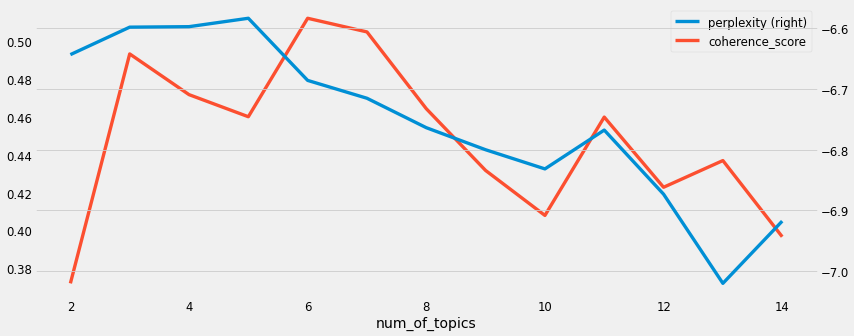

In [29]:
results.plot(secondary_y='perplexity')
plt.show()

In [30]:
results

,perplexity,coherence_score
num_of_topics,,
2,-6.643297,0.372050
3,-6.598058,0.493253
4,-6.597260,0.471741
5,-6.583420,0.460073
6,-6.685770,0.512085
7,-6.715167,0.504870
8,-6.763639,0.464306
9,-6.799965,0.431680
10,-6.831515,0.407935


In [31]:
# Compute Perplexity
print('\nPerplexity of the Optimal Model: ', optimal_model.log_perplexity(corpus))  

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=optimal_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score of the Optimal Model: ', coherence_lda)


Perplexity of the Optimal Model:  -6.685769954496954

Coherence Score of the Optimal Model:  0.5120850613987369


# Visualize the topics

In [32]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.149861  0.133805       1        1  39.623923
0      0.228982  0.062773       2        1  17.145623
2     -0.009162 -0.058696       3        1  16.930616
3     -0.042463 -0.082541       4        1  13.148847
1     -0.028879 -0.056572       5        1  13.148564
4      0.001384  0.001231       6        1   0.002427, topic_info=          Term       Freq      Total Category  logprob  loglift
594    mineral  16.000000  16.000000  Default  30.0000  30.0000
59    employee  19.000000  19.000000  Default  29.0000  29.0000
37    conflict  21.000000  21.000000  Default  28.0000  28.0000
291    privacy   8.000000   8.000000  Default  27.0000  27.0000
28   community   8.000000   8.000000  Default  26.0000  26.0000
..         ...        ...        ...      ...      ...      ...
125    partner   0.000062   6.857555   Topic6  -6.6946  -0.9870
129     policy   0.000062  14.059168   Topic6  -6.6946  -1.7049
711    benefit   0.000062   2.535368   Topic6  -6.6946   0.0080
722    content   0.000062   2.535368   Topic6  -6.6946   0.0080
710      award   0.000062   2.535368   Topic6  -6.6946   0.0080

[371 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
189       3  0.794252      access
3         5  0.813562    accurate
6         4  0.428442    activity
6         5  0.428442    activity
8         1  0.762011  additional
...     ...       ...         ...
186       1  0.536312        work
186       2  0.321787        work
186       3  0.107262        work
186       4  0.107262        work
706       1  0.800881       world

[441 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 1, 3, 4, 2, 5])

In [33]:
# Print the Keyword in the 6 topics
pprint(optimal_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.031*"employee" + 0.022*"community" + 0.016*"network" + 0.015*"resource" + '
  '0.013*"woman" + 0.013*"leave" + 0.013*"group" + 0.012*"training" + '
  '0.011*"provide" + 0.011*"pay"'),
 (1,
  '0.018*"conduct" + 0.014*"employee" + 0.013*"policy" + 0.013*"code" + '
  '0.011*"ethical" + 0.011*"business" + 0.009*"report" + 0.009*"hotline" + '
  '0.009*"anti" + 0.009*"governance"'),
 (2,
  '0.023*"privacy" + 0.021*"security" + 0.018*"cybersecurity" + 0.017*"policy" '
  '+ 0.012*"team" + 0.012*"business" + 0.012*"information" + 0.011*"employee" '
  '+ 0.011*"datum" + 0.009*"protect"'),
 (3,
  '0.021*"trade" + 0.013*"export" + 0.013*"security" + 0.013*"global" + '
  '0.013*"team" + 0.011*"restriction" + 0.011*"regulation" + 0.010*"business" '
  '+ 0.009*"international" + 0.009*"import"'),
 (4,
  '0.001*"employee" + 0.001*"group" + 0.001*"network" + 0.001*"provide" + '
  '0.001*"training" + 0.001*"leave" + 0.001*"woman" + 0.001*"community" + '
  '0.001*"pay" + 0.001*"week"'),
 (5,
  '

In [ ]:
1. 怎么总结主题
2. 注释需要人修改
3. 代码得完全看懂
3. 无环境方面的事情？
4. 词云搞出来的高频词汇，好像无用
5.fsi_stop_words 需要讨论